In [120]:
import numpy as np
from typing import Dict, List
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from celluloid import Camera
import time 
from IPython.display import HTML

In [121]:
class Grid:
    def __init__(self, max_x: int, max_y: int) -> None:
        self.gridxsize = max_x
        self.gridysize = max_y
        self.generate_coords()
        self.animals_in_grid = [[[] for _ in range(max_y)] for _ in range(max_x)]
        
    def generate_coords(self) -> None:
        xcoords = np.arange(self.gridxsize)
        ycoords = np.arange(self.gridysize)
        self.coords = np.transpose([np.tile(xcoords, len(ycoords)), np.repeat(ycoords, len(xcoords))])

In [122]:
class Species():
    def __init__(self, PredatorOrPrey: str, E_0: int, E_procreation: float, N: int, Grid_instance: object) -> None:
        self.pred_or_prey = PredatorOrPrey
        self.initial_energy = E_0
        self.min_procreation_energy = E_procreation
        self.num_agents = N
        self.agents : List[object] = []
        
        self.grid = Grid_instance
        self.species_coords = np.random.permutation(self.grid.coords)[:self.num_agents]
        
        
    def move(self):
        self.species_coords = np.zeros( shape=(len(self.agents),2) )
        directions = ["LEFT", "RIGHT", "UP", "DOWN"]
        for i, agent in enumerate(self.agents):
            dir_index = np.random.randint(4)
            agent.move(directions[dir_index])
            self.species_coords[i] = [agent.x, agent.y]
        

    def interact(self):
        for agent1 in self.agents:
            for agent2 in self.agents:
                if agent1.x == agent2.x and agent1.y == agent2.y:
                    agent1.interact(agent2)

    def procreate(self):
        for agent1 in self.agents:
            for agent2 in self.agents:
                if agent1 != agent2 and agent1.energy + agent2.energy > self.min_procreation_energy:
                    agent1.procreate(agent2)

In [127]:
class Agent(Species):
    
    def __init__(self, species: object, agent_number: int, energy=None) -> None:
        super().__init__(species.pred_or_prey, 
                         species.initial_energy, 
                         species.min_procreation_energy, 
                         species.num_agents, 
                         species.grid)
        self.parent_species = species

        y_or_d_condition = ('y' if self.pred_or_prey == "Prey" else 'd')
        self.agent_id = f"{y_or_d_condition}{agent_number}"

        self.x = self.species_coords[agent_number][0]
        self.y = self.species_coords[agent_number][1]

        if energy is not None:  self.energy = energy
        else: self.energy = species.initial_energy
        
        
        
    def interact(self, other):
        if self.pred_or_prey == other.pred_or_prey and self.energy + other.energy > self.min_procreation_energy:
            self.procreate(other)
        
        if (other.pred_or_prey, self.pred_or_prey) == ("Predator", "Prey"):
            self.die()
            
    def die(self):
        self.num_agents-=1
        self.x = 2*self.grid.gridxsize
        self.y = 2*self.grid.gridysize
        
    def procreate(self, other):
        print(self.species_coords[self.num_agents-1])
        self.num_agents+=1
        self.species_coords = np.append(self.species_coords, [[self.x, self.y]], axis=0)
        print(self.species_coords[self.num_agents-1])
        y_or_d_condition = ('y' if self.pred_or_prey == "Prey" else 'd')
        Baby = Agent(self.parent_species, f"{y_or_d_condition}{len(self.species_coords)}", energy=(self.energy + other.energy)/2)
        self.Agents.append(Baby)       
    
    def move(self, direction : str):
        
        if self.agent_id in self.grid.animals_in_grid[self.x][self.y]:
            self.grid.animals_in_grid[self.x][self.y].remove(self.agent_id)
        
        self.energy -=1
        if direction == "LEFT":
            self.x += -1 if self.x > 0 else +1
        if direction == "RIGHT":
            self.x += 1 if self.x < self.grid.gridxsize-1 else -1
        if direction == "UP":
            self.y += 1 if self.y < self.grid.gridysize-1 else -1
        if direction == "DOWN":
            self.y += -1 if self.y > 0 else +1
        
        self.grid.animals_in_grid[self.x][self.y].append(self.agent_id)
        
        if self.energy <= 0: self.die() 

In [128]:
def initialise_agents(species_instance: object):
    for i in range(species_instance.num_agents):
        this_agent = Agent(species_instance, i)
        species_instance.agents.append(this_agent)
        agent_x = species_instance.species_coords[i, 0]
        agent_y = species_instance.species_coords[i, 1]
        y_or_d_condition = ('y' if species_instance.pred_or_prey == "Prey" else 'd')
        species_instance.grid.animals_in_grid[agent_x][agent_y] = [f'{y_or_d_condition}{i}']

def plot_frame(fig, ax, Prey, Pred):
    gridxsize, gridysize = Prey.grid.gridxsize, Prey.grid.gridysize
    x_prey, y_prey = zip(*Prey.species_coords)
    x_pred, y_pred = zip(*Pred.species_coords)
    prey_scatter = ax.scatter(x_prey, y_prey, c='green')
    pred_scatter = ax.scatter(x_pred, y_pred, c='red')
    ax.set(xlim=(0, gridxsize), ylim=(0, gridysize))
    plt.axis('off')
    return fig, ax

def timeme(method):
    def wrapper(*args, **kw):
        startTime = int(round(time.time() * 1000))
        result = method(*args, **kw)
        endTime = int(round(time.time() * 1000))
        print(endTime - startTime,'ms')
        return result
    return wrapper

def interact(Prey_species_obj, Pred_species_obj, Grid_obj):
    for y_i in range(Grid_obj.gridysize):
        for x_i in range(Grid_obj.gridxsize):
            if not Grid_obj.animals_in_grid[y_i][x_i]: pass
            preys, preds = [], []
            for agent_str in Grid_obj.animals_in_grid[y_i][x_i]:
                if agent_str[0] == 'y': preys.append(int(agent_str[1:]))
                if agent_str[0] == 'd': preds.append(int(agent_str[1:]))

                # Predators procreate
                if not len(preds) >= 2: pass
                else: 
                    for i in range(0, len(preds)-1, 2):
                        pred_mum = Pred_species_obj.agents[preds[i]]
                        pred_dad = Pred_species_obj.agents[preds[i+1]]
                        pred_mum.interact(pred_dad)

                # Predators feed on prey
                if not preys or not preds: pass
                else: 
                    for i in range(len(preds)):
                        if i <= len(preys):
                            predator = Pred_species_obj.agents[preds[i]]
                            food = Prey_species_obj.agents[preys[i]]
                            predator.interact(food)

                # Preys procreate
                if not len(preys) >= 2: pass
                else:
                    for i in range(0, len(preys)-1, 2):
                        prey_mum = Prey_species_obj.agents[preys[i]]
                        prey_dad = Prey_species_obj.agents[preys[i+1]]
                        prey_mum.interact(prey_dad)               

In [129]:
coords = np.array([[1,2],
          [3,4],
          [5,6]])

coords = np.append(coords, [[7,8]], axis=0)
print(coords)

preds = [1,2,3,4,5,6]
if not len(preds) >= 2: pass
else: 
    for i in range(0, len(preds)-1, 2):
        print(preds[i],"has sex with",preds[i+1])

[[1 2]
 [3 4]
 [5 6]
 [7 8]]
1 has sex with 2
3 has sex with 4
5 has sex with 6


[72 48]
[51 48]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

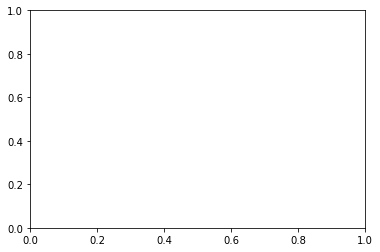

In [130]:
gridxsize = 100
gridysize = 100

Prey_E0 = 10
Prey_EP = 8
Prey_N = 500

Pred_E0 = 20
Pred_EP = 16
Pred_N = 500
    
TheGrid = Grid(gridxsize, gridysize)

Prey = Species("Prey", Prey_E0, Prey_EP, Prey_N, TheGrid)
initialise_agents(Prey)

Pred = Species("Predator", Pred_E0, Pred_EP, Pred_N, TheGrid)
initialise_agents(Pred)

fig, ax = plt.subplots()
camera = Camera(fig)

for i in range(10):
    Prey.move()
    Pred.move()
    interact(Prey, Pred, TheGrid)
    fig, ax = plot_frame(fig, ax, Prey, Pred)
    camera.snap()

plt.close()
animation = camera.animate()
HTML(animation.to_html5_video())